testcases data shape: (101784, 3)


Creating the test cases graph: 100%|██████████| 511300/511300 [00:01<00:00, 302565.58it/s]



Total number of graph nodes: 17482
Total number of graph edges: 511300
Average node degree: 58.49


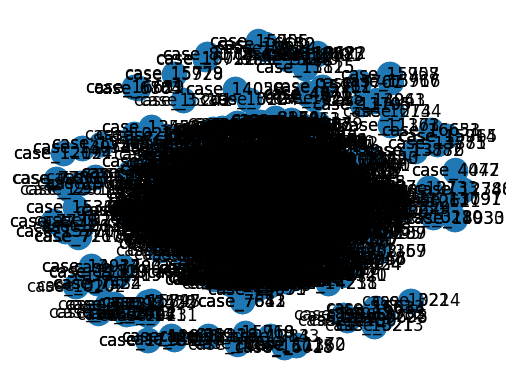

In [3]:
import math
import networkx as nx
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from node2vec import Node2Vec
import matplotlib.pyplot as plt

# Create a graph

# Load testcases to a DataFrame.
# !Details of Pandas Dataframe is here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
# !How to use Lambda is here: https://www.w3schools.com/python/python_lambda.asp
testcases = pd.read_csv("dataset/assertj-core2.csv")
# Create a "id" string.
testcases["id"] = testcases["id"].apply(lambda x: f"case_{x}")

# !pandas.DataFrame.shape return a tuple representing the dimensionality of the DataFrame
print("testcases data shape:", testcases.shape)

# Construct the Testcase graph

# Step 1: create the weighted edges between movies
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Group instances by executed line.
cases_grouped_by_executed_line = list(testcases.groupby("executedline"))
for group in tqdm(
    cases_grouped_by_executed_line,
    position=0,
    leave=True,
    desc="Compute test cases frequency",
):
    # Get a list of test cases executing the line.
    #print(group)
    current_cases = list(group[1]["id"])

    for i in range(len(current_cases)):
        item_frequency[current_cases[i]] += 1
        for j in range(i + 1, len(current_cases)):
            x = min(current_cases[i], current_cases[j])
            y = max(current_cases[i], current_cases[j])
            pair_frequency[(x, y)] += 1

# Step 2: create the graph with the nodes and the edges
#min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
testcases_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the test cases graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    #if weight >= min_weight:
    #    movies_graph.add_edge(x, y, weight=weight)
    testcases_graph.add_edge(x, y, weight=weight)


# Let's display the total number of nodes and edges in the graph. 
# Note that the number of nodes is less than the total number of test cases, 
# since only the test cases that have edges to other test cases are added.
print()
print("Total number of graph nodes:", testcases_graph.number_of_nodes())
print("Total number of graph edges:", testcases_graph.number_of_edges())

# Let's display the average node degree (number of neighbours) in the graph.
degrees = []
for node in testcases_graph.nodes:
    degrees.append(testcases_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

fig, ax = plt.subplots()
nx.draw_networkx(testcases_graph)
ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')


In [4]:
# Create Embedding
node2vec = Node2Vec(testcases_graph, dimensions=2)

model = node2vec.fit(window=10)

embeddings = model.wv

Generating walks (CPU: 1): 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]
